# What is best way to normalize MCSS feature?

Short answer: Just don't

More conservative answer: None of the ways I incorporated a normalizing term resulted in comparable seperation between native and decoy poses than leaving the rmsds unnormalized.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve
import sys
sys.path.append('../3_analyze')
from density_estimate import DensityEstimate

%matplotlib inline

In [2]:
data = {}
no_mcss, mcss = 0, 0
with open('../../combind_data/bpp_outputs/mcss.csv') as fp:
    for line in fp:
        if 'None' in line:
            no_mcss += 1
            continue
        protein,ligand1,ligand2,r1,r2,rmsd,rmsd1,rmsd2 = line.strip().split(',')
        if protein not in data: data[protein] = {}
        k = '{}-{}'.format(ligand1, ligand2)
        if k not in data[protein]:
            mcss += 1
            data[protein][k] = [[], []]
        data[protein][k][0] += [float(rmsd)]
        data[protein][k][1] += [float(rmsd1) <= 2.0 and float(rmsd2) <= 2.0]
print mcss, no_mcss

114 481


In [3]:
for protein, ligpairs in data.items():
    for k, rmsds in ligpairs.items():
        ligpairs[k] = np.array(rmsds).T

# What is the best way to normalize?

In [4]:
def evaluate(flat):
    native = flat[flat[:, 1]==1, 0]
    decoy  = flat[flat[:, 1]==0, 0]

    plt.hist([native, decoy], normed = True)
    plt.show()

    # Discriminatory power
    print roc_auc_score(flat[:, 1]==1, -flat[:, 0])
    tpr, fpr, thresh = roc_curve(flat[:, 1]==1, flat[:, 0])
    plt.plot(fpr, tpr)
    plt.show()

## No Normalization

(907156, 2)


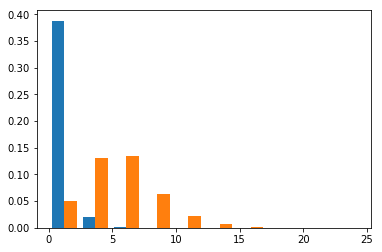

0.971303520374


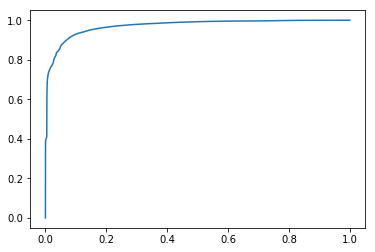

In [5]:
flat = np.vstack([rmsds
                  for protein, ligpairs in data.items()
                  for k, rmsds in ligpairs.items()])
print flat.shape
evaluate(flat)

## Normalization by max

(907156, 2)


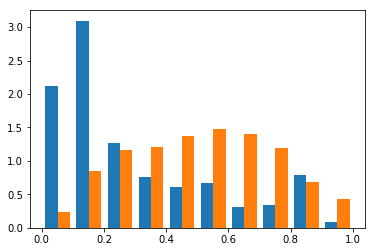

0.747133090871


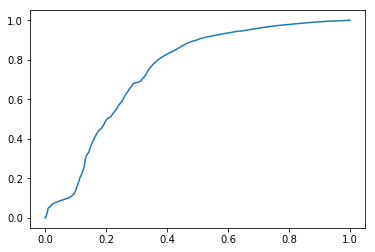

In [6]:
flat = np.vstack([rmsds / np.array([rmsds[:, 0].max(), 1])
                  for protein, ligpairs in data.items()
                  for k, rmsds in ligpairs.items()])

print flat.shape

evaluate(flat)

## Normalization by max(max, k)

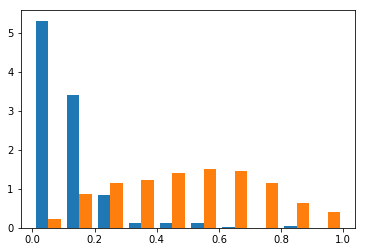

0.942708445338


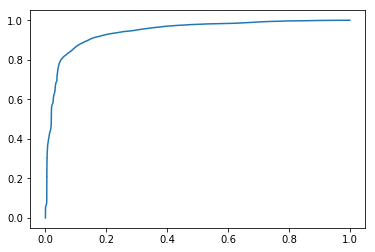

In [7]:
k = 6.0
flat = np.vstack([rmsds / np.array([np.max([k, rmsds[:, 0].max()]), 1])
                  for protein, ligpairs in data.items()
                  for key, rmsds in ligpairs.items()])

evaluate(flat)

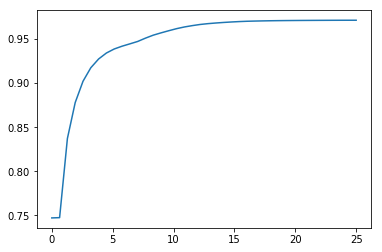

In [8]:
# Performance as function of k
K = np.linspace(0, 25, 40)

rocs = []
for k in K:
    flat = np.vstack([rmsds / np.array([np.max([k, rmsds[:, 0].max()]), 1])
                      for protein, ligpairs in data.items()
                      for key, rmsds in ligpairs.items()])
    rocs += [roc_auc_score(flat[:, 1]==1, -flat[:, 0])]

plt.plot(K, rocs)
plt.show()

# Density Estimates of unnormalized

Hopefully with more data sparse regions will smooth out, but if not saturate at some value.

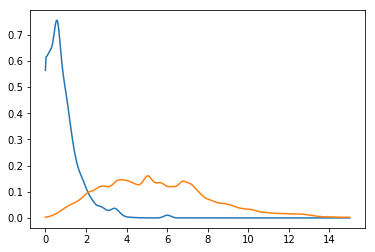

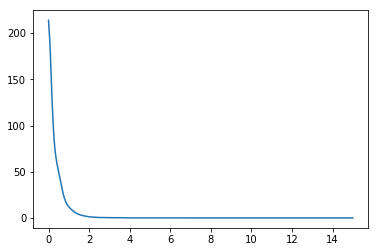

/Users/jpaggi/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:15: RuntimeWarning: divide by zero encountered in log


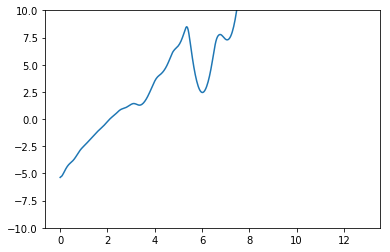

In [4]:
flat = np.vstack([rmsds
                  for protein, ligpairs in data.items()
                  for k, rmsds in ligpairs.items()])

native = DensityEstimate(reflect=True, domain = (0, 15), points = 500, sd = 0.15).fit(flat[flat[:, 1]==1, 0])
decoy = DensityEstimate(reflect=True, domain = (0, 15), points = 500, sd = 0.15).fit(flat[flat[:, 1]==0, 0])

plt.plot(native.x, native.fx)
plt.plot(decoy.x, decoy.fx)
plt.show()

ratio = native.ratio(decoy)
plt.plot(ratio.x, ratio.fx)
plt.show()
plt.plot(ratio.x, -np.log(ratio.fx))
plt.ylim(-10, 10)
plt.show()

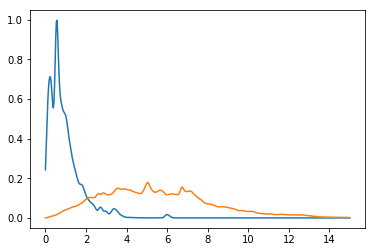

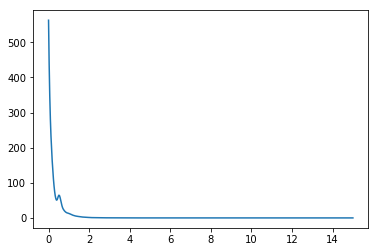

/Users/jpaggi/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:15: RuntimeWarning: divide by zero encountered in log


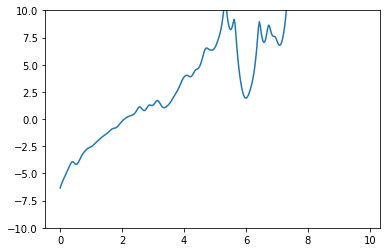

In [7]:
flat = np.vstack([rmsds
                  for protein, ligpairs in data.items()
                  for k, rmsds in ligpairs.items()])

native = DensityEstimate(reflect=False, domain = (0, 15), points = 500, sd = 0.07).fit(flat[flat[:, 1]==1, 0])
decoy = DensityEstimate(reflect=False, domain = (0, 15), points = 500, sd = 0.07).fit(flat[flat[:, 1]==0, 0])

plt.plot(native.x, native.fx)
plt.plot(decoy.x, decoy.fx)
plt.show()

ratio = native.ratio(decoy)
plt.plot(ratio.x, ratio.fx)
plt.show()
plt.plot(ratio.x, -np.log(ratio.fx))
plt.ylim(-10, 10)
plt.show()